In [1]:
# !pip install pandas
# !pip install torch
# !pip install torchtext
# !pip install transformers
#!pip install matplotlib

In [2]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
import torch
from torchtext import data
from transformers import BertTokenizer

# Using the BERT model for tokenizing.
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Function to tokenize words and cut sentences exceeding the max length.
def tokenize_and_cut(sentence):
    max_input_length = tokenizer.max_model_input_sizes['bert-base-uncased']
    tokens = tokenizer.tokenize(sentence) 
    tokens = tokens[:max_input_length-2]
    return tokens

test_field = data.Field(batch_first = True,
                  use_vocab = False,
                  tokenize = tokenize_and_cut,
                  preprocessing = tokenizer.convert_tokens_to_ids,
                  init_token = tokenizer.cls_token_id,
                  eos_token = tokenizer.sep_token_id,
                  pad_token = tokenizer.pad_token_id,
                  unk_token = tokenizer.unk_token_id)

label_field = data.LabelField(dtype = torch.float)

# Loading the training dataset.
train_dataset = data.TabularDataset(
path='../data/Proble4Dataset_large_train.csv', format='csv', skip_header=True,
fields=[('text', test_field),
        ('label', label_field)])

# Loading the testing dataset.
test_data = data.TabularDataset(
path='../data/Proble4Dataset_large_test.csv', format='csv', skip_header=True,
fields=[('text', test_field),
        ('label', label_field)])

# Splitting the training data into 80% train and 20% validation sets.
train_data, valid_data = train_dataset.split(split_ratio=0.8)

# Building the vocabulary for the labels
label_field.build_vocab(train_data)

print(f"Number of training examples: {len(train_data)}")
print(f"Number of validation examples: {len(valid_data)}")
print(f"Number of testing examples: {len(test_data)}")

Number of training examples: 800
Number of validation examples: 200
Number of testing examples: 200


In [4]:
# Defining the batch size.
batch_size = 5

# Iterators for the training, validation and test sets.
train_iterator = data.BucketIterator(train_data, batch_size = batch_size, device = device)
valid_iterator = data.BucketIterator(valid_data, batch_size = batch_size, device = device)
test_iterator = data.BucketIterator(test_data, batch_size = batch_size, device = device)

In [5]:
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

bert = BertModel.from_pretrained('bert-base-uncased')

In [6]:
init_token = tokenizer.cls_token
eos_token = tokenizer.sep_token
pad_token = tokenizer.pad_token
unk_token = tokenizer.unk_token

print(init_token, eos_token, pad_token, unk_token)

[CLS] [SEP] [PAD] [UNK]


In [7]:
max_input_length = tokenizer.max_model_input_sizes['bert-base-uncased']

print(max_input_length)

512


In [8]:
def tokenize_and_cut(sentence):
    tokens = tokenizer.tokenize(sentence) 
    tokens = tokens[:max_input_length-2]
    return tokens

In [9]:
init_token_idx = tokenizer.cls_token_id
eos_token_idx = tokenizer.sep_token_id
pad_token_idx = tokenizer.pad_token_id
unk_token_idx = tokenizer.unk_token_id

print(init_token_idx, eos_token_idx, pad_token_idx, unk_token_idx)

101 102 0 100


In [10]:
import torch
from torchtext import data

TEXT = data.Field(batch_first = True,
                  use_vocab = False,
                  tokenize = tokenize_and_cut,
                  preprocessing = tokenizer.convert_tokens_to_ids,
                  init_token = init_token_idx,
                  eos_token = eos_token_idx,
                  pad_token = pad_token_idx,
                  unk_token = unk_token_idx)

LABEL = data.LabelField(dtype = torch.float)

In [11]:
import torch.nn as nn

class BERTGRUSentiment(nn.Module):
    def __init__(self,
                 bert,
                 hidden_dim,
                 output_dim,
                 n_layers,
                 bidirectional,
                 dropout):
        
        super().__init__()
        
        self.bert = bert
        
        embedding_dim = bert.config.to_dict()['hidden_size']
        
        self.rnn = nn.GRU(embedding_dim,
                          hidden_dim,
                          num_layers = n_layers,
                          bidirectional = bidirectional,
                          batch_first = True,
                          dropout = 0 if n_layers < 2 else dropout)
        
        self.out = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        
        #text = [batch size, sent len]
                
        with torch.no_grad():
            embedded = self.bert(text)[0]
                
        #embedded = [batch size, sent len, emb dim]
        
        _, hidden = self.rnn(embedded)
        
        #hidden = [n layers * n directions, batch size, emb dim]
        
        if self.rnn.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        else:
            hidden = self.dropout(hidden[-1,:,:])
                
        #hidden = [batch size, hid dim]
        
        output = self.out(hidden)
        
        #output = [batch size, out dim]
        
        return output

In [12]:
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.25

model = BERTGRUSentiment(bert,
                         HIDDEN_DIM,
                         OUTPUT_DIM,
                         N_LAYERS,
                         BIDIRECTIONAL,
                         DROPOUT)

In [13]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 112,241,409 trainable parameters


In [14]:
for name, param in model.named_parameters():                
    if name.startswith('bert'):
        param.requires_grad = False


In [15]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 2,759,169 trainable parameters


In [16]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

In [17]:
criterion = nn.BCEWithLogitsLoss()

In [18]:
model = model.to(device)
criterion = criterion.to(device)

In [19]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [20]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        predictions = model(batch.text).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [21]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.text).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [22]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [23]:
import time

N_EPOCHS = 20

best_valid_loss = float('inf')

train_losses_lst = []
valid_losses_lst = []

# Auditing the start time.
start_time_total = time.time()

for epoch in range(N_EPOCHS):
    start_time = time.time()

    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
        
    end_time = time.time()
        
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'bert-large-model.pt')
    
    train_losses_lst.append(train_loss)
    valid_losses_lst.append(valid_loss)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    
# Auditing the start time.
time_taken_total = time.time() - start_time_total
print("Training Time :: ", time_taken_total)

Epoch: 01 | Epoch Time: 0m 6s
	Train Loss: 0.764 | Train Acc: 52.88%
	 Val. Loss: 0.640 |  Val. Acc: 67.50%
Epoch: 02 | Epoch Time: 0m 6s
	Train Loss: 0.632 | Train Acc: 65.38%
	 Val. Loss: 0.639 |  Val. Acc: 64.50%
Epoch: 03 | Epoch Time: 0m 6s
	Train Loss: 0.570 | Train Acc: 71.00%
	 Val. Loss: 0.648 |  Val. Acc: 60.50%
Epoch: 04 | Epoch Time: 0m 6s
	Train Loss: 0.518 | Train Acc: 75.50%
	 Val. Loss: 0.675 |  Val. Acc: 69.50%
Epoch: 05 | Epoch Time: 0m 6s
	Train Loss: 0.458 | Train Acc: 77.50%
	 Val. Loss: 0.685 |  Val. Acc: 67.00%
Epoch: 06 | Epoch Time: 0m 6s
	Train Loss: 0.386 | Train Acc: 83.38%
	 Val. Loss: 0.710 |  Val. Acc: 69.00%
Epoch: 07 | Epoch Time: 0m 6s
	Train Loss: 0.293 | Train Acc: 86.88%
	 Val. Loss: 0.838 |  Val. Acc: 64.50%
Epoch: 08 | Epoch Time: 0m 6s
	Train Loss: 0.203 | Train Acc: 92.38%
	 Val. Loss: 0.919 |  Val. Acc: 67.50%
Epoch: 09 | Epoch Time: 0m 6s
	Train Loss: 0.156 | Train Acc: 93.25%
	 Val. Loss: 1.120 |  Val. Acc: 63.00%
Epoch: 10 | Epoch Time: 0m 6

In [24]:
model.load_state_dict(torch.load('bert-large-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.688 | Test Acc: 58.50%


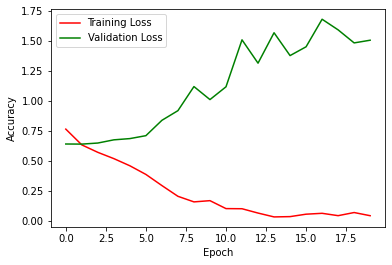

<Figure size 432x288 with 0 Axes>

In [25]:
# Plotting the learning curves.
import matplotlib.pyplot as plt

plt.plot(train_losses_lst, 'r', label="Training Loss")
plt.plot(valid_losses_lst, 'g', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.savefig('BERT-Large.png')

In [26]:
def predict_sentiment(model, sentence):
    model.eval()
    tokens = tokenizer.tokenize(sentence)
    tokens = tokens[:max_input_length-2]
    indexed = [init_token_idx] + tokenizer.convert_tokens_to_ids(tokens) + [eos_token_idx]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(0)
    prediction = torch.sigmoid(model(tensor))
        
    # Converting the output into a predicted class (0 or 1).
    prediction = torch.round(prediction.squeeze())
    
    return prediction.item()

In [27]:
predict_sentiment(model, "This is a word!")

1.0

In [28]:
import pandas as pd
import numpy as np

# Loading the training dataset.
train_data_input = pd.read_csv("../data/Proble4Dataset_large_train.csv")
train_data_input = train_data_input.reindex(np.random.permutation(train_data_input.index)) # Shuffling the data.

# Loading the testing dataset.
test_data_input = pd.read_csv("../data/Proble4Dataset_large_test.csv")

# Sample text and its label.
train_data_input[:5]

,Text,Label
915,"#um# I mean, I don't know if I'll be around bu...",0
600,"Oh, it went fine. Yeah, no problem, I mean it'...",0
527,#uh# we take em' to #uh# it's not well it's fr...,0
433,"Right, okay, and I have been working with #uhh...",1
409,Yeah 'Wen_Wednesday' would work better for me ...,1


In [29]:
# Defining the function for getting the confusion matrix.
def confusion(prediction, truth):
    confusion_vector = prediction / truth
    
    true_positives = torch.sum(confusion_vector == 1).item()
    false_positives = torch.sum(confusion_vector == float('inf')).item()
    true_negatives = torch.sum(torch.isnan(confusion_vector)).item()
    false_negatives = torch.sum(confusion_vector == 0).item()

    return true_positives, false_positives, true_negatives, false_negatives

In [30]:
# Obtaining the confusion matrix for the training dataset.
prediction_lst = []
for text, label in zip(train_data_input["Text"], train_data_input["Label"]):
    prediction_lst.append(predict_sentiment(model, text))
    
true_positives, false_positives, true_negatives, false_negatives = confusion(
    torch.Tensor(prediction_lst), torch.tensor(train_data_input["Label"].to_numpy()))

accuracy = (true_positives + true_negatives)/len(prediction_lst)
print("Accuracy :: ", accuracy)
print("Confusion Matrix :: \n", true_positives, "\t", false_positives, "\n", false_negatives, "\t", true_negatives)

Accuracy ::  0.734
Confusion Matrix :: 
 352 	 118 
 148 	 382


In [31]:
# Obtaining the confusion matrix for the testing dataset.
prediction_lst = []
for text, label in zip(test_data_input["Text"], test_data_input["Label"]):
    prediction_lst.append(predict_sentiment(model, text))

true_positives, false_positives, true_negatives, false_negatives = confusion(
    torch.Tensor(prediction_lst), torch.Tensor(test_data_input["Label"].to_numpy()))
accuracy = (true_positives + true_negatives)/len(prediction_lst)

print("Accuracy :: ", accuracy)
print("Confusion Matrix :: \n", true_positives, "\t", false_positives, "\n", false_negatives, "\t", true_negatives)

Accuracy ::  0.6
Confusion Matrix :: 
 54 	 34 
 46 	 66
